# Fundamental Graph Neural Network for Edge Prediction in MNIST Dataset

## Imports and CUDA

In [2]:
# Core libraries
import time
import numpy as np

# PyTorch and related imports
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Spatial distance computation
from scipy.spatial.distance import cdist

# Ensure reproducibility in CUDA operations if available
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.deterministic = True

In [3]:
# Setting up plotting within the Jupyter notebook
from matplotlib import pyplot as plt
%matplotlib inline

## Configuration Parameters

In [4]:
# ##############################
# ## Configuration Parameters ##
# ##############################

# Computing Device Configuration
COMPUTE_DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training Hyperparameters
SEED = 1
LR = 0.0005  # Learning Rate
EPOCH_COUNT = 50
BATCH_SZ = 128  # Batch Size
IMAGE_DIM = 28  # Image Dimension

# Neural Network Architecture
CLASS_COUNT = 10  # Number of Classes

## MNIST Dataset Preparation

In [5]:
# Define indices for training and validation sets
indices_train = torch.arange(0, 59000)
indices_valid = torch.arange(59000, 60000)

# Image transformation pipeline
transform_pipeline = transforms.Compose([transforms.ToTensor()])

# MNIST datasets
mnist_train_valid = datasets.MNIST(root='data', 
                                   train=True, 
                                   transform=transform_pipeline,
                                   download=True)

mnist_test = datasets.MNIST(root='data', 
                            train=False, 
                            transform=transform_pipeline,
                            download=True)

# Creating subsets for train and validation
dataset_train = Subset(mnist_train_valid, indices_train)
dataset_valid = Subset(mnist_train_valid, indices_valid)

# Data Loaders for training, validation, and test sets
loader_train = DataLoader(dataset=dataset_train, 
                          batch_size=BATCH_SZ,  # Updated variable name
                          num_workers=4,
                          shuffle=True)

loader_valid = DataLoader(dataset=dataset_valid, 
                          batch_size=BATCH_SZ,  # Updated variable name
                          num_workers=4,
                          shuffle=False)

loader_test = DataLoader(dataset=mnist_test, 
                         batch_size=BATCH_SZ,  # Updated variable name
                         num_workers=4,
                         shuffle=False)

# Quick check of the dataset
for imgs, lbls in loader_train:  
    print('Image batch dimensions:', imgs.shape)
    print('Image label dimensions:', lbls.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Graph Neural Network Model

In [6]:
# ############################
# ## Graph Neural Network Model
# ############################

def create_2d_coord_array(size_img, size_output=4):
    """ Generate 2D coordinate array for a square image. """
    n_pixels = size_img * size_img
    x_coords, y_coords = np.meshgrid(np.arange(size_img), np.arange(size_img))
    coords = np.stack((x_coords, y_coords), axis=2).reshape(-1, 2)
    coords = (coords - np.mean(coords, axis=0)) / (np.std(coords, axis=0) + 1e-5)
    coords = torch.from_numpy(coords).float()

    # Reshape to [N, N, size_output]
    coords = torch.cat((coords.unsqueeze(0).repeat(n_pixels, 1,  int(size_output/2-1)),
                        coords.unsqueeze(1).repeat(1, n_pixels, 1)), dim=2)
    return coords


class GNNModel(nn.Module):
    def __init__(self, size_img=28, features_coord=4, num_classes=10):
        super(GNNModel, self).__init__()

        n_pixels = size_img**2
        self.fc = nn.Linear(n_pixels, num_classes, bias=False)

        coords = create_2d_coord_array(size_img, features_coord)
        self.register_buffer('coords', coords)

        # Edge Predictor Network
        self.edge_predictor = nn.Sequential(nn.Linear(features_coord, 32),  # coord to hidden
                                            nn.ReLU(),
                                            nn.Linear(32, 1),  # hidden to edge
                                            nn.Tanh())

    def forward(self, x):
        batch_size = x.size(0)

        # Edge Prediction
        self.adj_matrix = self.edge_predictor(self.coords).squeeze()

        # Reshape Adjacency Matrix for batch processing
        adj_tensor = self.adj_matrix.unsqueeze(0)
        adj_tensor = adj_tensor.expand(batch_size, -1, -1)

        # Reshape inputs for processing
        x_reshaped = x.view(batch_size, -1, 1)
        avg_neighbor_features = torch.bmm(adj_tensor, x_reshaped).view(batch_size, -1)

        output_logits = self.fc(avg_neighbor_features)
        output_probas = F.softmax(output_logits, dim=1)
        return output_logits, output_probas

## Model Initialization and Optimizer Setup

In [7]:
# Set random seed for reproducibility
torch.manual_seed(SEED)

# Initialize the GNN model with specified parameters
gnn_model = GNNModel(size_img=IMAGE_DIM, num_classes=CLASS_COUNT)

# Transfer the model to the designated computing device
gnn_model = gnn_model.to(COMPUTE_DEVICE)

# Set up the optimizer for the model's parameters
model_optimizer = torch.optim.Adam(gnn_model.parameters(), lr=LR)

## Training Loop and Accuracy Computation

In [8]:
def calculate_accuracy(network, loader, compute_device):
    correct_preds, total_samples = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(compute_device), labels.to(compute_device)
        output_logits, output_probas = network(inputs)
        _, predicted = torch.max(output_probas, 1)
        total_samples += labels.size(0)
        correct_preds += (predicted == labels).sum()
    return correct_preds.float() / total_samples * 100

# Record starting time
training_start_time = time.time()

# Lists to store cost and accuracy
costs, accuracy_train, accuracy_valid = [], [], []

# Training loop
for epoch in range(EPOCH_COUNT):
    
    gnn_model.train()  # Set model to training mode
    for batch_index, (inputs, labels) in enumerate(loader_train):
        
        inputs, labels = inputs.to(COMPUTE_DEVICE), labels.to(COMPUTE_DEVICE)
        
        # Forward and backward propagation
        output_logits, output_probas = gnn_model(inputs)
        loss = F.cross_entropy(output_logits, labels)
        model_optimizer.zero_grad()
        loss.backward()
        model_optimizer.step()
        
        # Logging
        costs.append(loss.item())
        if not batch_index % 150:
            print(f'Epoch: {epoch+1:03d}/{EPOCH_COUNT:03d} | '
                  f'Batch {batch_index:03d}/{len(loader_train):03d} | '
                  f'Loss: {loss:.4f}')

    # Evaluation mode
    gnn_model.eval()
    with torch.no_grad():  # Disable gradient computation
        acc_train = calculate_accuracy(gnn_model, loader_train, COMPUTE_DEVICE)
        acc_valid = calculate_accuracy(gnn_model, loader_valid, COMPUTE_DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{EPOCH_COUNT:03d}\n'
              f'Training Accuracy: {acc_train:.2f} | Validation Accuracy: {acc_valid:.2f}')
        
        accuracy_train.append(acc_train)
        accuracy_valid.append(acc_valid)
        
    time_elapsed = (time.time() - training_start_time) / 60
    print(f'Time elapsed: {time_elapsed:.2f} min')
  
total_time = (time.time() - training_start_time) / 60
print(f'Total Training Time: {total_time:.2f} min')

Epoch: 001/050 | Batch 000/461 | Cost: 24.2727
Epoch: 001/050 | Batch 150/461 | Cost: 2.2706
Epoch: 001/050 | Batch 300/461 | Cost: 1.8713
Epoch: 001/050 | Batch 450/461 | Cost: 1.5048
Epoch: 001/050
Train ACC: 50.39 | Validation ACC: 54.80
Time elapsed: 0.25 min
Epoch: 002/050 | Batch 000/461 | Cost: 1.4445
Epoch: 002/050 | Batch 150/461 | Cost: 1.3288
Epoch: 002/050 | Batch 300/461 | Cost: 1.1868
Epoch: 002/050 | Batch 450/461 | Cost: 1.2040
Epoch: 002/050
Train ACC: 67.68 | Validation ACC: 71.40
Time elapsed: 0.49 min
Epoch: 003/050 | Batch 000/461 | Cost: 1.2128
Epoch: 003/050 | Batch 150/461 | Cost: 0.9953
Epoch: 003/050 | Batch 300/461 | Cost: 0.9818
Epoch: 003/050 | Batch 450/461 | Cost: 1.0487
Epoch: 003/050
Train ACC: 68.09 | Validation ACC: 73.40
Time elapsed: 0.74 min
Epoch: 004/050 | Batch 000/461 | Cost: 1.0444
Epoch: 004/050 | Batch 150/461 | Cost: 0.9064
Epoch: 004/050 | Batch 300/461 | Cost: 0.9152
Epoch: 004/050 | Batch 450/461 | Cost: 0.7396
Epoch: 004/050
Train ACC: 

## Visualization of the Final Adjacency Matrix

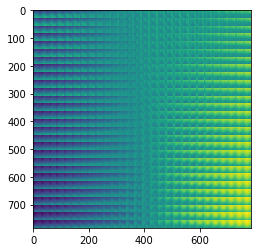

In [9]:
# Visualizing the Final Adjacency Matrix
plt.imshow(gnn_model.adj_matrix.to('cpu'));

## Plotting Training Cost and Running Average

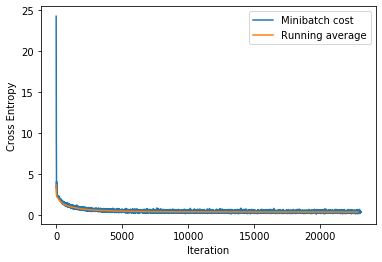

In [10]:
# Plot Training Loss and Its Running Average
plt.plot(costs, label='Minibatch cost')  
plt.plot(np.convolve(costs, np.ones(200)/200, mode='valid'), 
         label='Running Average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

## Plotting Training and Validation Accuracy per Epoch

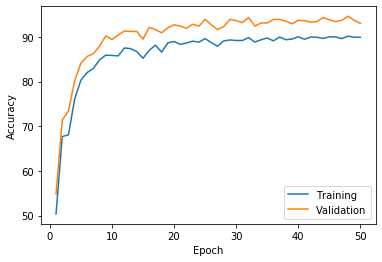

In [11]:
# Plot Accuracy for Training and Validation Sets Across Epochs
plt.plot(np.arange(1, EPOCH_COUNT + 1), accuracy_train, label='Training')  # Updated train_acc_list to accuracy_train
plt.plot(np.arange(1, EPOCH_COUNT + 1), accuracy_valid, label='Validation')  # Updated valid_acc_list to accuracy_valid

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Computing and Displaying Validation and Test Accuracy

In [12]:
# Compute and Display Accuracy on Validation and Test Sets
with torch.no_grad():  # Disables gradient calculation
    accuracy_test = calculate_accuracy(network=gnn_model, 
                                       loader=loader_test, 
                                       compute_device=COMPUTE_DEVICE)

    accuracy_validation = calculate_accuracy(network=gnn_model, 
                                             loader=loader_valid, 
                                             compute_device=COMPUTE_DEVICE)

print(f'Validation Acc: {accuracy_validation:.2f}%')
print(f'Test Acc: {accuracy_test:.2f}%')

Validation ACC: 93.00%
Test ACC: 90.36%


## Imported Library Versions

In [13]:
%watermark -iv

torchvision 0.4.0a0+6b959ee
matplotlib  3.1.0
torch       1.2.0
numpy       1.16.4

